# Outage probability in OFDMA protocol

## MACS 207B

### Arnaud Capitan

___

Librairies I will be using for this project :

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy.stats import poisson, kstest

___

In this project, we want to estimate for one time slot the probability that the cumulative number of required subchannels by the set of active customer at a given time is greater than the number of available resources.

We will be considering that :

- The emitter is given severak subcarriers for a few time slots, thus building a subchannel
- The number of allocated frequency bins is fixed during the ON period
- The number of subcarriers needed by a user located at x, who wants to communicate at a rate C is given by :

$ N(x) = \lceil \dfrac{C}{W \log _2(1+\dfrac{K}{||x||^{\gamma}})} \rceil $, if $K ||x|| ^{-\gamma} > \text{SNR}_{min}$

where $\text{SNR}_{min}$ is the minimum signal over noise ratio necessary to ensure the feasibility of the communication.

- The users are represented by a Poisson process of intensity measure $\lambda dx$
- The active users in a time slot is a percentage $p$ of those users. Since this percentage of active user isn't said to be the same at each time slot, we assume that for each time slot the distribution of the active users follow a Bernouilli($p$) distribution for each user.   
- The access point is located at (0,0), and the observation window is a circle of radius $R$

___

A first results, is that we have an upper bound of the number of slots per user : 

If we take $x$ such that $||x||^{\gamma} = \dfrac{K}{\text{SNR}_{min}}$ (maximum norm value of $x$) :

$$ N_{max} = \lceil \dfrac{C}{W \log _2(1+\dfrac{K}{1 + \text{SNR}_{min}})} \rceil $$

___

We also have the numerical values :

In [19]:
C = 200000 #bits/s
W = 250000 #Hz
K = 1000000
gamma = 2.8
R = 300 #m
lambda_poisson = 0.01 #/m²
SNR_min = 0.1
p = 0.01
S_min = 30
S_max = 100

# Questions

___

1]

The process of users is a Poisson process of intensity measure $\lambda dx$ and the active users in a time slot is a percentage $p$ of those users. As mentioned above, since this percentage of active user isn't said to be the same at each time slot, we assume that for each time slot the distribution of the active users follow a Bernouilli($p$) distribution for each user.  

Thus the process of active users is a thinning of the Poisson process of users by the coefficient $p$, thus resulting by a theorem of the course (Theorem 5.7 (Thinning)) to a Poisson process of intensity measure $\lambda p dx$.

___

2] 

To compute the mean number of active customers in the cell, we need to compute the expectation of the number of active customers.

By Campbell's formula (Theorem 5.2), we have :

$\mathbb{E}[n_{\text{Active customers}}] = \int _E \lambda p dx$

With E being the observation window, which is  a circle of radius R.

We then obtain :

$\mathbb{E}[n_{\text{Active customers}}] = \lambda p \pi R^2$

We can do the computation with the exact values :

In [20]:
n_active_customers = lambda_poisson*p*np.pi*R**2
print(f"Mean number of active customers: {n_active_customers:.5f}")

Mean number of active customers: 28.27433


___

3]

For $1 \leq k \leq N_{max}$, we want to describe geometrically the subset of the cell in which all customers require k subcarriers.

This means that we want to describe geometrically the distribution of $x$ for which $N(x) = k$

$\lceil \dfrac{C}{W \log _2(1+\dfrac{K}{||x||^{\gamma}})} \rceil = k$

$k-1 < \dfrac{C}{W \log _2(1+\dfrac{K}{||x||^{\gamma}})} \leq k$

$ 2^{\dfrac{C}{W(k-1)}} > 1 + \dfrac{K}{||x||^{\gamma}} \geq 2^{\dfrac{C}{Wk}}$

$ \dfrac{K}{2^{\frac{C}{W(k-1)}} - 1} < ||x||^{\gamma} \leq \dfrac{K}{2^{\frac{C}{Wk}} - 1} $

$ (\dfrac{K}{2^{\frac{C}{W(k-1)}} - 1})^{\frac{1}{\gamma}} < ||x|| \leq (\dfrac{K}{2^{\frac{C}{Wk}} - 1})^{\frac{1}{\gamma}} $

So the subset of the cell in which all customers require k subcarriers is a ring-shaped region defined by :

- Its internal radius $r_{in}(k) = (\dfrac{K}{2^{\frac{C}{W(k-1)}} - 1})^{\frac{1}{\gamma}}$
- Its external radius $r_{ext}(k) = (\dfrac{K}{2^{\frac{C}{Wk}} - 1})^{\frac{1}{\gamma}}$

If $k = 1$, we have $r_{in}(1) = 0$, because we have a division by 0 otherwise that would give the same result.

___

4] The distribution of $A_3$, the number of (active) customers requiring 3 subcarriers is by Theorem 5.3. following a Poisson distribution with parameter $\mu (Area(r_{in}(3),r_{out}(3)))$

We compute this value :

$\mu (Area(r_{in}(3),r_{out}(3))) = \lambda p Area(r_{in}(3),r_{out}(3))$

$\mu (Area(r_{in}(3),r_{out}(3))) = \lambda p \pi (r_{in}(3)^2 - r_{out}(3)^2)$

Thus, $A_3$ is following a distribution of a Poisson process of parameter :

$$ A_3 \sim \mathcal{P} (\lambda p \pi (r_{in}(3)^2 - r_{out}(3)^2)) $$

We can compute the value of the parameter :

In [21]:
N_max = np.ceil(C / (W * np.log2(1 + SNR_min)))

def subcarriers(x_norm):
    SNR = K * x_norm**(-gamma)
    if SNR < SNR_min:
        return 0 #The user cannot be served
    return (np.ceil(C / (W * np.log2(1 + SNR))))

def r_in(k):
    if k == 1:
        return 0
    dist = (K/(2**(C/(W*(k-1)))-1))**(1/gamma)
    if dist > R:
        return R
    return(dist)

def r_ext(k):
    dist = (K/(2**(C/(W*k))-1))**(1/gamma)
    if dist > R:
        return R
    return(dist)    

A_3_parameter = lambda_poisson*p*np.pi*(r_ext(3)**2-r_in(3)**2)
print(f"A3 parameter: {A_3_parameter:.5f}")

A3 parameter: 5.24130


___

5] 

We want to use the Kolmogorov-Smirnov test (with a low p-value like 0.05) to see if $A_3 \sim \mathcal{P}(5.24130)$ follows this distribution or not.

To do this :
- We simulate the number of users using a Poisson process (the mean number of users can be computed as in the question 2], we obtain $\lambda \pi R^2$)
- We simulate their position in the circle, to know how many subcarriers they will require (we only need the distance, so the angle is not computed)
- We then apply a probability filter to only have a percentage $p$ for the number of active users
- Then we look at the number of active users requiring 3 subcarriers
- We repeat the previous steps $n_{\text{trials}}$ times
- Then we finally look at the distribution using the kstest (Kolmogorov-Smirnov test) from numpy function to see if the distributions match

In [22]:
def generate_users():
    area = np.pi*R**2
    n_users = np.random.poisson(lambda_poisson*area) #Mean number of users
    users_distance = R*np.sqrt(np.random.uniform(0,1,n_users))
    return users_distance

def simulate_A3_sample():
    users = generate_users()
    is_active = np.random.rand(len(users)) < p #We only consider active users, so we filter using a mask
    active_users_distance = users[is_active]
    num_subcarriers = np.array([subcarriers(r) for r in active_users_distance])
    return np.sum(num_subcarriers == 3)

In [81]:
n_trials = 100
A3_samples = np.array([simulate_A3_sample() for _ in range(n_trials)])

_, p_value = kstest(A3_samples, poisson(5.24130).cdf)
print(f"p-value for the Kolmogorov-Smirnov test : {p_value:.10f}")

p-value for the Kolmogorov-Smirnov test : 0.0208055529


Using $n_{\text{trials} = 100}$, which means that we have 100 values for the number of users in A3, we have a p-value that is below 0.05 on average (you can execute the cell above to have a new p-value). 

The Kolmogorov-Smirnov test is unsuccesful in showing that :

$$A_3 \sim \mathcal{P}(5.24130)$$

This is because the Kolmogorov-Smirnov test is not made for discrete distributions like the Poisson Process, thus having unsuccesful results when in fact the distributions do match.

___

6]

We have $F(\phi) = \sum_{x \in \phi} N(x)$, the number of subcarriers required by a set of users $\phi$

If we compute this sum not by the set of users $\phi$ containing $x$ but by the number of subcarriers required $k$, we get :

$F(\phi) = \sum_{k = 1} ^{N_{max}} k n_{\text{users requiring k subcarriers}}$

We write $n_{\text{users requiring k subcarriers}} = \zeta _k$

We will now show that $(\zeta _k)_{0 \leq k \leq N_{max}}$ are independant random variables with Poisson distribution (to be determined) :

We know that the number of active users using $k$ subcarriers (in a ring-shaped area, according to question 3]) follows a Poisson process of intensity $\lambda p \pi (r_{in}(k)^2 - r_{out}(k)^2)$ (same calculations as question 4]).

Furthermore, since the regions are disjoint (no areas are overlapping), the random variables are independant.

So we have independant random variables :

$\zeta _k \sim \mathcal{P}(\lambda p \pi (r_{in}(k)^2 - r_{out}(k)^2))$ for $1 \leq k \leq N_{max}$

And :

$F(\phi) = \sum_{k = 1} ^{N_{max}} k \zeta _k$

___

7]

We want to compute $\mathbb{E}[e^{\theta X_{\mu}}]$ for $X_{\mu}$ a Poisson random variable of parameter $\mu$

$\mathbb{E}[e^{\theta X_{\mu}}] = \sum_{k=0}^{+\infty} \dfrac{e^{\theta k} \mu^k}{k!} e^{-\mu}$

$\mathbb{E}[e^{\theta X_{\mu}}] = \sum_{k=0}^{+\infty} \dfrac{(e^{\theta} \mu)^k}{k!} e^{-\mu}$

$\mathbb{E}[e^{\theta X_{\mu}}] = e^{\mu (e^{\theta}-1)}$

by using the exponential series.


We then want to compute $\min _{\theta > 0} e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}]$

We differentiate the function with respect to $\theta$ the following expression :

$e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}] = e^{-K \mu \theta}e^{\mu (e^{\theta}-1)} = e^{-K \mu \theta + \mu (e^{\theta}-1)}$

$\dfrac{d}{d \theta} (e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}]) = e^{-K \mu \theta + \mu (e^{\theta}-1)} \dfrac{d}{d \theta}(-K \mu \theta + \mu (e^{\theta}-1))$

$\dfrac{d}{d \theta} (e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}]) = \mu (e^{\theta}-K) e^{-K \mu \theta + \mu (e^{\theta}-1)}$

$\dfrac{d}{d \theta} (e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}]) = 0 \iff \theta = \ln (K) > 0$

So we have : 

$\min _{\theta > 0} e^{-K \mu \theta} \mathbb{E}[e^{\theta X_{\mu}}] = e^{- \mu (K \ln (K) - K + 1)}$

___

8] 

The first inequality comes from the Markov inequality. We have in fact :

$\mathbb{P}(X _{\mu} \geq K \mu) = \mathbb{P}(e^{\theta X _{\mu}} \geq e^{\theta K \mu})$

Because $x \rightarrow e^{\theta x}$ is an increasing function for $x \in \mathbb{R}$

We then apply Markov's inequality :

$\mathbb{P}(X _{\mu} \geq K \mu) \leq e^{-\theta K \mu} \mathbb{E}[e^{\theta X_{\mu}}]$

7] gives that the minimum of the right-side value is reached when $\theta = \ln (K)$

Thus obtaining : 

$\mathbb{P}(X _{\mu} \geq K \mu) \leq e^{- \mu (K \ln (K) - K + 1)}$

We want to find the value $K _{\mu}$ such that :

$e^{- \mu (K _{\mu} \ln (K _{\mu}) - K _{\mu} + 1)} \leq 10^{-4}$

We see that this identity allows us to compute numerically the distribution of a Poisson random variable of intensity $\mu$ with the sequence :

$e^{- \mu} \dfrac{\mu ^k}{k!} $, for $0 \leq k \leq K_{\mu}$

Thus $K_{\mu}$ is an integer.

We can solve it numerically given $\mu$ :

In [24]:
def K_mu(mu):
    k = 1
    while np.exp(-mu*(k*np.log(k)-k+1)) > 0.0001: #I applied np.log to avoid overflow
        k += 1
    return(k)

___

9] We recall that :

$\zeta _k \sim \mathcal{P}(\lambda p \pi (r_{in}(k)^2 - r_{out}(k)^2))$ for $1 \leq k \leq N_{max}$

So :

$\mathbb{E}[\zeta _k] = \lambda p \pi (r_{in}(k)^2 - r_{out}(k)^2)$

In [25]:
N_max = int(np.ceil(C / (W * np.log2(1 + SNR_min))))
print(f"Maximum number of subcarriers: {N_max}")

mean_zeta_k = np.zeros(N_max)

for k in range(1, N_max+1):
    mean_zeta_k[k-1] = lambda_poisson*p*np.pi*(r_ext(k)**2-r_in(k)**2)
    print(f"Mean number of users served with {k} subcarriers: {mean_zeta_k[k-1]:.5f}")

Maximum number of subcarriers: 6
Mean number of users served with 1 subcarriers: 7.51292
Mean number of users served with 2 subcarriers: 6.18977
Mean number of users served with 3 subcarriers: 5.24130
Mean number of users served with 4 subcarriers: 4.71924
Mean number of users served with 5 subcarriers: 4.37078
Mean number of users served with 6 subcarriers: 0.24032


In [26]:
print(f"Total mean number of users served: {np.sum(mean_zeta_k):.5f}")
print(f"Mean number of active customers: {n_active_customers:.5f}")

Total mean number of users served: 28.27433
Mean number of active customers: 28.27433


The numbers match as expected.

In [27]:
vector_sizes = []
for k in range(1, N_max + 1):
    mu = mean_zeta_k[k-1]
    vector_sizes.append(K_mu(mu))
supremum_K = max(vector_sizes)

print(f"Vector sizes for each zeta_k : {vector_sizes}")
print(f"Supremum K of these dimensions : {supremum_K}")


Vector sizes for each zeta_k : [3, 4, 4, 4, 4, 20]
Supremum K of these dimensions : 20


In [28]:
zeta_distributions = []
for k in range(1, N_max+1):
    mu_k = mean_zeta_k[k-1]
    k_values = np.arange(supremum_K+1)
    zeta_dist = np.exp(-mu_k)*(mu_k**k_values)
    for i in range(1,supremum_K+1):
        zeta_dist[i] = np.exp(-mu_k)*(mu_k**i)/factorial(i)
    zeta_distributions.append(zeta_dist)

We can display the distribution of the $(\zeta _k)_{0 \leq k \leq N_{max}}$ :

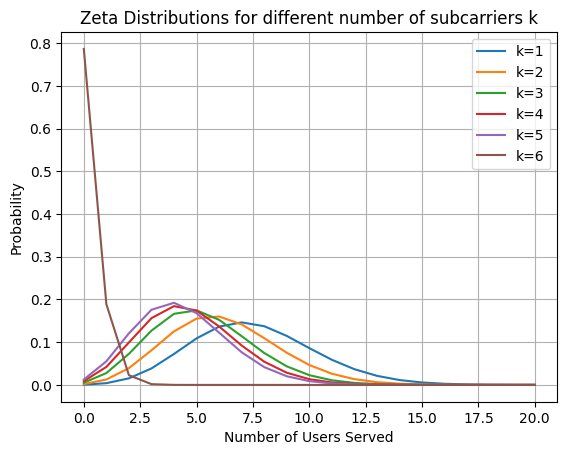

In [29]:
for k,elem in enumerate(zeta_distributions):
    plt.plot(np.arange(len(elem)), elem, label=f'k={k+1}')
plt.title('Zeta Distributions for different number of subcarriers k')
plt.xlabel('Number of Users Served')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.show()

In [30]:
k_zeta_distributions = []
for k, zeta_dist in enumerate(zeta_distributions, start=1):
    values = np.arange(len(zeta_dist))*k
    k_zeta_distributions.append((values, zeta_dist))

In [31]:
F_dist = zeta_distributions[0]
for k in range(2, N_max+1):
    stretched = np.zeros((len(zeta_distributions[k-1])-1)*k+1)
    stretched[::k] = zeta_distributions[k-1]
    F_dist = np.convolve(F_dist, stretched)


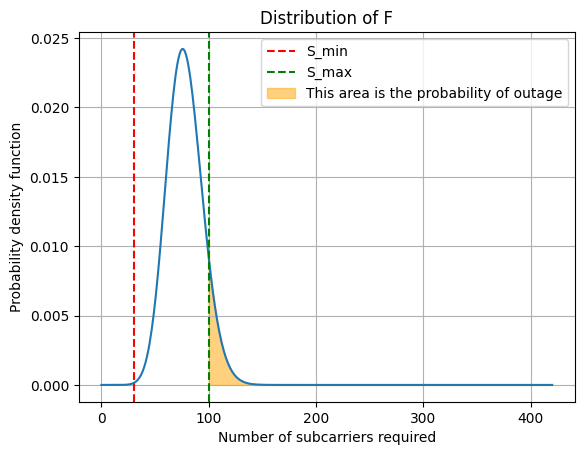

In [32]:
plt.plot(np.arange(len(F_dist)), F_dist)
plt.title('Distribution of F')
plt.xlabel('Number of subcarriers required')
plt.ylabel('Probability density function')
plt.axvline(S_min, color='red', linestyle='--', label='S_min')
plt.axvline(S_max, color='green', linestyle='--', label='S_max')
plt.fill_between(np.arange(len(F_dist)), F_dist, where=(np.arange(len(F_dist)) >= S_max), color='orange', alpha=0.5, label='This area is the probability of outage')
plt.legend()
plt.grid()
plt.show()

___

10] We want to compute $S_{max}$ so that the outpage probability is smaller than 0.01

I took $S_{max} = 100$ for the above plot, as given by the subject. We use the function np.cumsum to compute the cumululative distribution function, thanks to the values within F_dist

In [33]:
def compute_S_max(F_dist, threshold=0.01):
    cdf = np.cumsum(F_dist)
    for S in range(len(cdf)):
        if 1 - cdf[S] < threshold:
            return S
    return len(cdf) - 1

S_max_computed = compute_S_max(F_dist)
print(f"Computed S_max : {S_max_computed}")

Computed S_max : 119


We get that $S_{max} = 119$ gives us an outage probability smaller than 0.01, which is better than $S_{max} = 100$ as per the subject which had an outage probability of 0.0896.

In [34]:
outage_probability = 1 - np.sum(F_dist[:S_max + 1])
print(f"Outage probability for S_max = {S_max} : {outage_probability:.4f}")

Outage probability for S_max = 100 : 0.0896
